<a href="https://colab.research.google.com/github/Bihela/ML_FashionMINST/blob/main/ML_FashionMINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip wheel==0.38.4 setuptools==65.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# For Functionality
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from d2l import torch as d2l
torch.autograd.set_detect_anomaly(True)

# My Imports
import time

**DESCRIPTION ON ORIGINAL CODE:** I'll try my best to explain how the residual block works. Basically think of it in a mathematicall perspective. Instead of having a multilayer percpetron going z(x) = w`z`*y(x)+b`z`, where y(x) = w`y`*x+b`y` so they are nested basically the output from the NN Block going to y(x) is the input for the NN Block for z(x).


```
Model by Math: (Nested Model)
y(x) = wy*x+by
z(x) = wz*y(x)+bz

Model in a layered nature: (Nested Model)
x --> y(x) --> z(x) --> model_output
```



The residual network considers the input itself and is not nested to the output of another layer. This is as its primary intention is to solve diminishing weights.

```
Model by Math: (Non-nested Model)
y(x) = activation(x)
z(x) = activation(y(x)+x)

Model in a layered nature: (Non-nested Model)
x --> y(x) --> z(x) --> model_output
|           ^       ^
|           |       |
 --------------------
```



---

Now this does not mean, I can understand the complexity in layers and structures. The way I understand it more layers better but slower and it is harder to visualize it with convolution as there are layers to format the outputs.

**As seen in these images in the book:**

![In a regular block (left), the portion within the dotted-line box must directly learn the mapping $f(\mathbf{x})$. In a residual block (right), the portion within the dotted-line box needs to learn the residual mapping $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$, making the identity mapping $f(\mathbf{x}) = \mathbf{x}$ easier to learn.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/residual-block.svg?raw=1)
:label:`fig_residual_block`

**These show the non-nested and nested nature of the two types:**

![For non-nested function classes, a larger (indicated by area) function class does not guarantee to get closer to the "truth" function ($f^*$). This does not happen in nested function classes.](http://d2l.ai/_images/functionclasses.svg)
:label:`fig_functionclasses`



In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [ ]:
class ResidualCUS(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, res_ks = 3, padds = 1, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=res_ks, padding=padds,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=res_ks, padding=padds)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

**DESCRIPTION ON ORIGINAL CODE:** Not using it yet, do not plan to use it yet. Same as residual but kinda can do parallel layers.

In [ ]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

**DESCRIPTION ON ORIGINAL CODE:** Allows us to make a residual layer basically, its super object is the d2l.classifier class so expect meaningfull-gibberish from there. Also same in context to other nn.block components.

Hey just noticed look at the init, it is basically constructing the neural network for the required number of blocks, which I presume is what arch is doing but yeah however you can see it.


**This line on the init is the magic line as it refers to the parent object constructor which we cant see here, so this takes in arch and makes the resnet18 neaural network defined in the resnet18 object below:**

*super(ResNet, self).__init__()*


```
# This line makes the neural block ->
self.net = nn.Sequential(self.b1())
#Making the blocks of our requirement defined in the block function of the object ->
for i, b in enumerate(arch):
    self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
#Making the last layer ->
self.net.add_module('last', nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
    nn.LazyLinear(num_classes)))
self.net.apply(d2l.init_cnn)

Original Constructor:

def __init__(self, arch, lr=0.1, num_classes=10, momentum = None, weight_decay = None):
        super(ResNet, self).__init__(momentum = momentum, weight_decay = weight_decay)
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)
```




**ATTEMPT TO CUSTOMIZE CLASSIFIER:**

In [ ]:
class NewClassifier(d2l.Classifier):
    def __init__(self, momentum = None, weight_decay = None):
        super(NewClassifier, self).__init__()
        self.momentum = momentum
        self.weight_decay = weight_decay

    def configure_optimizers(self):
        """Defined in :numref:`sec_linear_concise`"""
        if (self.momentum != None and self.weight_decay != None):
            return torch.optim.SGD(self.parameters(), self.lr, momentum = self.momentum, weight_decay = self.weight_decay)
        else:
            return torch.optim.SGD(self.parameters(), self.lr)

**RESNET Object**

In [ ]:
class ResNet(NewClassifier):
    """The ResNet Block"""
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=8, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2, padding=1))

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10, momentum = None, weight_decay = None):
        super(ResNet, self).__init__(momentum = momentum, weight_decay = weight_decay)
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

In [ ]:
class ResNetCUS(NewClassifier):
    """The ResNet Block"""
    def b1(self, b1_ks = 7, b1_stride = 2, b1_padd = 3, b2_ks = 5, b2_stride = 3, b2_padd = 1):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=b1_ks, stride=b1_stride, padding=b1_padd),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=b2_ks, stride=b2_stride, padding=b2_padd))

    def block(self, num_residuals, num_channels, res_kernel_size = 3, res_padding = 1, res_strides = 1, in_res_strides = 2, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(ResidualCUS(num_channels, use_1x1conv=True, strides=in_res_strides))
            else:
                blk.append(ResidualCUS(num_channels, res_kernel_size = res_kernel_size, res_padding = res_padding, strides = res_strides))
        return nn.Sequential(*blk)

    def __init__(self, arch, b1_ks = 7, b1_stride = 2, b1_padd = 3, b2_ks = 5, b2_stride = 3, b2_padd = 1, res_kernel_size = 3, res_padding = 1, res_strides = 1, lr=0.1, num_classes=10, momentum = None, weight_decay = None, in_res_strides = 2):
        super(ResNetCUS, self).__init__(momentum = momentum, weight_decay = weight_decay)
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1(b1_ks = b1_ks, b1_stride = b1_stride, b1_padd = b1_padd, b2_ks = b2_ks, b2_stride = b2_stride, b2_padd = b2_padd))
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, res_kernel_size = res_kernel_size, res_padding = res_padding, res_strides = res_strides,  in_res_strides = in_res_strides, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

In [ ]:
class ResNeXt(NewClassifier):
    """The ResNet Block"""
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=5, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def block(self, num_residuals, num_channels, groups, bot_mul, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul, use_1x1conv=True, strides=2))
            else:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul))
        return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10, momentum = None, weight_decay = None):
        super(ResNeXt, self).__init__(momentum = momentum, weight_decay = weight_decay)
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

**ATTEMPT AT IMPLEMENTING A LEARNING RATE SCHEDULE:**

In [ ]:
class NewTrainer(d2l.Trainer):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0, step_size = None, gamma = None):
        super(NewTrainer, self).__init__(max_epochs, num_gpus = num_gpus, gradient_clip_val = gradient_clip_val)
        self.step_size = step_size
        self.gamma = gamma


    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        if (self.step_size != None and self.gamma != None):
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=self.step_size, gamma=self.gamma)
        else:
            self.scheduler = None
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
                #print(self.optim.param_groups[0]['momentum'])  # Print the momentum value
                #print(self.optim.param_groups[0]['weight_decay'])  # Print the weight decay value
            self.train_batch_idx += 1
        if self.scheduler:
            self.scheduler.step()
        #print(self.optim.param_groups[0]['lr'])
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

# New section

**DESCRIPTION ON ORIGINAL CODE:** Object defines the structure of the non-nested function classes, this is acheived by the tuples given making 18 ResNet layers of the structure printed below from the originally defined ResNet Class above. The diagram is confusing to me yet but I'll attach it here as well.

![The ResNet-18 architecture.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/resnet18-90.svg?raw=1)
:label:`fig_resnet18`



In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10, momentum = None, weight_decay = None):
        super().__init__(((2,64),(2,128),(2,256),(2,512)),
                         lr, num_classes, momentum = momentum, weight_decay = weight_decay)

class ResNetNUM(ResNet):
    def __init__(self, arch, lr=0.1, num_classes=10, momentum = None, weight_decay = None):
        super().__init__(arch, lr, num_classes, momentum = momentum, weight_decay = weight_decay)

class ResNEXTNUM(ResNeXt):
    def __init__(self, arch, lr=0.1, num_classes=10, momentum = None, weight_decay = None):
        super().__init__(arch, lr, num_classes, momentum = momentum, weight_decay = weight_decay)

**CUSTOM ARCH: ** Considering implementing an arch similar to that of the book. This might require some thought.

In [ ]:
class ResNet_CUS(ResNetCUS):
    def __init__(self, arch, b1_ks = 7, b1_stride = 2, b1_padd = 3, b2_ks = 5, b2_stride = 3, b2_padd = 1, res_kernel_size = 3, res_padding = 1, res_strides = 1, lr=0.1, num_classes=10, momentum = None, weight_decay = None):
        print(b1_ks)
        super().__init__(arch, lr, num_classes, b1_ks = b1_ks, b1_stride = b1_stride, b1_padd = b1_padd, b2_ks = b2_ks, b2_stride = b2_stride, b2_padd = b2_padd, res_kernel_size = res_kernel_size, res_padding = res_padding, res_strides = res_strides, momentum = momentum, weight_decay = weight_decay)

**MOD1:** I have defined training the actual model from the 8.6 chapter of d2l into a function called train_model with the intention of being able to easily do parameter sweeps and studying how the data is generated.


```
def train_model(data, learn_rate, epochs, in_bs, size, n_gpu, scheduler = None):
    model = ResNet18(lr=learn_rate)
    trainer = d2l.Trainer(max_epochs=epochs, num_gpus=n_gpu)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model, data)
    return(model)
```

**MOD2:** In order to implement a learning schedule, I refered chat gpt for the syntax and according to my understnading made the modification.



In [ ]:
def train_model(data, learn_rate, epochs, in_bs, size, n_gpu, momentum = None, weight_decay = None, step_size = None, gamma = None):
    model = ResNet18(lr = learn_rate, momentum = momentum,
                     weight_decay = weight_decay)
    trainer = NewTrainer(max_epochs = epochs, num_gpus = n_gpu,
                         step_size = step_size, gamma = gamma)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    start = time.time()
    trainer.fit(model, data)
    run_time = time.time() - start
    return(model, run_time)

In [ ]:
def train_CUSmodel(arch, data, learn_rate, epochs, in_bs, size, n_gpu, momentum = None, weight_decay = None, step_size = None, gamma = None):
    model = ResNetNUM(arch, lr = learn_rate, momentum = momentum,
                     weight_decay = weight_decay)
    trainer = NewTrainer(max_epochs = epochs, num_gpus = n_gpu,
                         step_size = step_size, gamma = gamma)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    start = time.time()
    trainer.fit(model, data)
    run_time = time.time() - start
    return(model, run_time)

In [ ]:
def train_CUSmodelv2(arch, data, learn_rate, epochs, in_bs, size, n_gpu, b1_ks = 7, b1_stride = 2, b1_padd = 3, b2_ks = 5, b2_stride = 3, b2_padd = 1, res_kernel_size = 3, res_padding = 1, res_strides = 1, momentum = None, weight_decay = None, step_size = None, gamma = None):
    model = ResNet_CUS(arch, b1_ks = b1_ks, b1_stride = b1_stride,
                       b1_padd = b1_padd, b2_ks = b2_ks, b2_stride = b2_stride,
                       b2_padd = b2_padd, res_kernel_size = res_kernel_size,
                       res_padding = res_padding, res_strides = res_strides,
                       lr = learn_rate, momentum = momentum, weight_decay = weight_decay)
    trainer = NewTrainer(max_epochs = epochs, num_gpus = n_gpu,
                         step_size = step_size, gamma = gamma)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    start = time.time()
    trainer.fit(model, data)
    run_time = time.time() - start
    return(model, run_time)

In [ ]:
def train_NXTmodel(arch, data, learn_rate, epochs, in_bs, size, n_gpu, momentum = None, weight_decay = None, step_size = None, gamma = None):
    model = ResNEXTNUM(arch, lr = learn_rate, momentum = momentum,
                     weight_decay = weight_decay)
    trainer = NewTrainer(max_epochs = epochs, num_gpus = n_gpu,
                         step_size = step_size, gamma = gamma)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    start = time.time()
    trainer.fit(model, data)
    run_time = time.time() - start
    return(model, run_time)

**MOD1:** Made it possible to time training the model and going to be my main space to test with different variables.



```
#MOD1: batch_size changes

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Declare Hyper-parameters
learning_rate = 0.01
epoch = 10
batch_size = 128
size = (96,96)

#Run Training:
data = d2l.FashionMNIST(batch_size=batch_size, resize=size)
start_time = time.time()
model = train_model(data,learning_rate,epoch,batch_size,size, n_gpu)
run_time = time.time() - start_time

#Generate Accuracy of Model:
X,y = next(iter(data.get_dataloader(False)))
model.eval()
with torch.no_grad():
    Y_hat = model(torch.FloatTensor(X).to(device))

#Print Output Data:
print("Time: ",run_time," | Accuracy: ", model.accuracy(Y_hat,y.to(device))," | Time Per Epoch: ",run_time/epoch)
```

**DEFINE BASELINE IN OUR CASE:**


```
# PARAMETERS FOR BASELINE:
18 Layered ResNet Model
BASELINE TIME = 445.08153080940247 s
Accuracy = 92.19 %
Learning Rate = 0.01
Epochs = 10
Batch Size = 128
Resize = (96 96)
```
**IMAGE OUTPUT:**
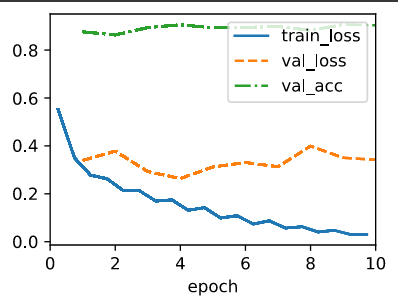
---

**MOD2:** Initail Changes the provided ref doc implies changing pre-processing time and dataloading. It mentions how in-its case some optimization was done to only load data once every training instance. I will ignore this as we only load data once when training the data. **However, preprocessing steps like (random, cropping and flipping) are functions that I cannot figure out at the moment so I will leave this out to the last.**

Hence MOD2 focuses mostly on playing around with the batch_size. I will set a case where the validation_error and train_error difference is taken at the lowest validation_error to compare between data samples.



```
#MOD2: batch_size changes

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Declare Hyper-parameters
learning_rate = 0.01
epoch = 10
batch_size_test = [128, 256, 512, 1024, 2048]
size = (96,96)

output = []

for batch_size in batch_size_test:
    #Run Training:
    data = d2l.FashionMNIST(batch_size=batch_size, resize=size)
    start_time = time.time()
    model = train_model(data,learning_rate,epoch,batch_size,size, n_gpu)
    run_time = time.time() - start_time

    #Generate Accuracy of Model:
    X,y = next(iter(data.get_dataloader(False)))
    model.eval()
    with torch.no_grad():
        Y_hat = model(torch.FloatTensor(X).to(device))

    #Print Output Data:
    output_str = "Batch_Size: " + str(batch_size) + " | Time: " + str(run_time) + " | Accuracy: " + str(model.accuracy(Y_hat,y.to(device))) + " | Time Per Epoch:" + str(run_time/epoch) + "\n"
    output.append(output_str)
print(output)

```



Initially testing by changing just the batch_size to 128, 256, 512, 1024 and 2048.

Extrapolated Data from the above tests:

Batch_Size: 128 | Time: 450.92761492729187 | Accuracy: tensor(0.9297, device='cuda:0') | Time Per Epoch:45.09276149272919

Batch_Size: 256 | Time: 445.07092118263245 | Accuracy: tensor(0.8906, device='cuda:0') | Time Per Epoch:44.507092118263245

Batch_Size: 512 | Time: 452.33217215538025 | Accuracy: tensor(0.8789, device='cuda:0') | Time Per Epoch:45.233217215538026

Batch_Size: 1024 | Time: 470.26202154159546 | Accuracy: tensor(0.8857, device='cuda:0') | Time Per Epoch:47.02620215415955

Batch_Size: 2048 | Time: 516.1877281665802 | Accuracy: tensor(0.8418, device='cuda:0') | Time Per Epoch:51.61877281665802

This shows us that as we increase the batch_size the speed does vary and deacreases when we test for a batch size of 256. It can be noted how the accuracy deacreases as we increase the batch_size. As the optimal learning speed is in-between 128 and 512. As the fastest time in the test is acheived at 256. I presume that the overall run_time goes up after the optimal point as it has to load bigger sets of data.

To further optimize for the batch-size I will run the code for 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480 and 512. To find the optimal batch_size.

Batch_Size: 128 | Time: 459.682519197464 | Accuracy: tensor(0.8828, device='cuda:0') | Time Per Epoch:45.9682519197464

Batch_Size: 160 | Time: 452.8316309452057 | Accuracy: tensor(0.9062, device='cuda:0') | Time Per Epoch:45.28316309452057

Batch_Size: 192 | Time: 450.0201334953308 | Accuracy: tensor(0.8229, device='cuda:0') | Time Per Epoch:45.00201334953308

Batch_Size: 224 | Time: 448.3974585533142 | Accuracy: tensor(0.9107, device='cuda:0') | Time Per Epoch:44.83974585533142

Batch_Size: 256 | Time: 450.8184986114502 | Accuracy: tensor(0.8945, device='cuda:0') | Time Per Epoch:45.08184986114502

Batch_Size: 288 | Time: 452.7571234703064 | Accuracy: tensor(0.9097, device='cuda:0') | Time Per Epoch:45.27571234703064

Batch_Size: 320 | Time: 448.6320524215698 | Accuracy: tensor(0.9187, device='cuda:0') | Time Per Epoch:44.86320524215698

Batch_Size: 352 | Time: 452.679322719574 | Accuracy: tensor(0.9006, device='cuda:0') | Time Per Epoch:45.2679322719574

Batch_Size: 384 | Time: 451.55810475349426 | Accuracy: tensor(0.9010, device='cuda:0') | Time Per Epoch:45.155810475349426

Batch_Size: 416 | Time: 458.0260672569275 | Accuracy: tensor(0.8269, device='cuda:0') | Time Per Epoch:45.80260672569275

Batch_Size: 448 | Time: 454.2349078655243 | Accuracy: tensor(0.8929, device='cuda:0') | Time Per Epoch:45.42349078655243

Batch_Size: 480 | Time: 457.23692631721497 | Accuracy: tensor(0.8896, device='cuda:0') | Time Per Epoch:45.7236926317215

Batch_Size: 512 | Time: 457.3530054092407 | Accuracy: tensor(0.8281, device='cuda:0') | Time Per Epoch:45.73530054092407

This provides that for the cases of 224 and 320 the lowest run time of all the simulations.

**MOD2 (LEARNING RATE):** The model has been tested for shifted learning rates and batch sizes. The batch sizes are 128, 320 and 512, with 128 for a small batch size, 320 as an optimal batch size and 512 for a large batch size.



```
#MOD2: batch_size changes

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Declare Hyper-parameters
learning_rate_test = [0.01, 0.1, 1, 4, 8, 12, 16]
epoch = 10
batch_size_test = [128, 320, 512]
size = (96,96)

output = []

for batch_size in batch_size_test:
    for learning_rate in learning_rate_test:
        #Run Training:
        data = d2l.FashionMNIST(batch_size=batch_size, resize=size)
        start_time = time.time()
        model = train_model(data,learning_rate,epoch,batch_size,size, n_gpu)
        run_time = time.time() - start_time

        #Generate Accuracy of Model:
        X,y = next(iter(data.get_dataloader(False)))
        model.eval()
        with torch.no_grad():
            Y_hat = model(torch.FloatTensor(X).to(device))

        #Print Output Data:
        output_str = "Batch_Size: " + str(batch_size) + " | Learning_rate: " + str(learning_rate) + " | Time: " + str(run_time) + " | Accuracy: " + str(model.accuracy(Y_hat,y.to(device))) + " | Time Per Epoch:" + str(run_time/epoch) + "\n"
        output.append(output_str)

for text in output:
    print(text)

```


Batch_Size: 128 | Learning_rate: 0.01 | Time: 452.68113470077515 | Accuracy: tensor(0.8984, device='cuda:0') | Time Per Epoch:45.268113470077516

Batch_Size: 128 | Learning_rate: 0.1 | Time: 439.880765914917 | Accuracy: tensor(0.9453, device='cuda:0') | Time Per Epoch:43.9880765914917

Batch_Size: 128 | Learning_rate: 1 | Time: 436.93935799598694 | Accuracy: tensor(0.8984, device='cuda:0') | Time Per Epoch:43.69393579959869

Batch_Size: 128 | Learning_rate: 4 | Time: 408.92196321487427 | Accuracy: tensor(0.0938, device='cuda:0') | Time Per Epoch:40.892196321487425

Batch_Size: 128 | Learning_rate: 8 | Time: 409.2066762447357 | Accuracy: tensor(0.0938, device='cuda:0') | Time Per Epoch:40.92066762447357

Batch_Size: 128 | Learning_rate: 12 | Time: 412.89217138290405 | Accuracy: tensor(0.0938, device='cuda:0') | Time Per Epoch:41.289217138290404

Batch_Size: 128 | Learning_rate: 16 | Time: 417.9568455219269 | Accuracy: tensor(0.0781, device='cuda:0') | Time Per Epoch:41.79568455219269

Batch_Size: 320 | Learning_rate: 0.01 | Time: 434.7748794555664 | Accuracy: tensor(0.9187, device='cuda:0') | Time Per Epoch:43.47748794555664

Batch_Size: 320 | Learning_rate: 0.1 | Time: 433.9300067424774 | Accuracy: tensor(0.9031, device='cuda:0') | Time Per Epoch:43.393000674247745

Batch_Size: 320 | Learning_rate: 1 | Time: 403.34937834739685 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:40.334937834739684

Batch_Size: 320 | Learning_rate: 4 | Time: 403.42556524276733 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:40.34255652427673

Batch_Size: 320 | Learning_rate: 8 | Time: 405.62717509269714 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:40.56271750926972

Batch_Size: 320 | Learning_rate: 12 | Time: 402.36063742637634 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:40.23606374263763

Batch_Size: 320 | Learning_rate: 16 | Time: 405.4757676124573 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:40.54757676124573

Batch_Size: 512 | Learning_rate: 0.01 | Time: 440.7553765773773 | Accuracy: tensor(0.7129, device='cuda:0') | Time Per Epoch:44.07553765773773

Batch_Size: 512 | Learning_rate: 0.1 | Time: 440.08400654792786 | Accuracy: tensor(0.9336, device='cuda:0') | Time Per Epoch:44.00840065479279

Batch_Size: 512 | Learning_rate: 1 | Time: 432.41598629951477 | Accuracy: tensor(0.8555, device='cuda:0') | Time Per Epoch:43.241598629951476

Batch_Size: 512 | Learning_rate: 4 | Time: 406.72665667533875 | Accuracy: tensor(0.1094, device='cuda:0') | Time Per Epoch:40.67266566753388

Batch_Size: 512 | Learning_rate: 8 | Time: 409.56339740753174 | Accuracy: tensor(0.1094, device='cuda:0') | Time Per Epoch:40.95633974075317

Batch_Size: 512 | Learning_rate: 12 | Time: 409.34352254867554 | Accuracy: tensor(0.1094, device='cuda:0') | Time Per Epoch:40.934352254867555

Batch_Size: 512 | Learning_rate: 16 | Time: 408.5555782318115 | Accuracy: tensor(0.1094, device='cuda:0') | Time Per Epoch:40.85555782318115


 As the fastest time was obtained at 0.1 for a batch size of 320, in order to further optimize the batch size and learning rates. I will be running a test by changing the learning rate between 0.1, 0.2, 0.3, 0.4 ,0.5 ,0.6 and 0.7. This time keeping the batch size at 320. The intention is to further optimize the training speed to acheive faster training.

Batch_Size: 320 | Learning_rate: 0.1 | Time: 449.1240360736847 | Accuracy: tensor(0.9219, device='cuda:0') | Time Per Epoch:44.91240360736847

Batch_Size: 320 | Learning_rate: 0.2 | Time: 443.32984232902527 | Accuracy: tensor(0.8875, device='cuda:0') | Time Per Epoch:44.332984232902525

Batch_Size: 320 | Learning_rate: 0.3 | Time: 440.9483518600464 | Accuracy: tensor(0.9187, device='cuda:0') | Time Per Epoch:44.09483518600464

Batch_Size: 320 | Learning_rate: 0.4 | Time: 438.7577350139618 | Accuracy: tensor(0.9062, device='cuda:0') | Time Per Epoch:43.87577350139618

Batch_Size: 320 | Learning_rate: 0.5 | Time: 414.75943064689636 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:41.47594306468964

Batch_Size: 320 | Learning_rate: 0.6 | Time: 415.0271940231323 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:41.50271940231323

Batch_Size: 320 | Learning_rate: 0.7 | Time: 412.79099774360657 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:41.27909977436066

The best data set obtained from the test above is the test set at 320 with learning rate of 0.4. This is the fastest more efficient data set. Just to be sure with a Learning Rate of 4, it would be intuitive to check if the batch size could be further optimized. Training it with the batch size from 256, 288, 320, 352, 384, 416. To ensure that the batch size is at the optimal point.

Batch_Size: 256 | Learning_rate: 0.4 | Time: 435.15621852874756 | Accuracy: tensor(0.2812, device='cuda:0') | Time Per Epoch:43.51562185287476

Batch_Size: 288 | Learning_rate: 0.4 | Time: 445.33411264419556 | Accuracy: tensor(0.8542, device='cuda:0') | Time Per Epoch:44.533411264419556

Batch_Size: 320 | Learning_rate: 0.4 | Time: 444.71785736083984 | Accuracy: tensor(0.8500, device='cuda:0') | Time Per Epoch:44.47178573608399

Batch_Size: 352 | Learning_rate: 0.4 | Time: 444.1641662120819 | Accuracy: tensor(0.9261, device='cuda:0') | Time Per Epoch:44.41641662120819

Batch_Size: 384 | Learning_rate: 0.4 | Time: 445.4641399383545 | Accuracy: tensor(0.8411, device='cuda:0') | Time Per Epoch:44.54641399383545

Batch_Size: 416 | Learning_rate: 0.4 | Time: 451.11480689048767 | Accuracy: tensor(0.8510, device='cuda:0') | Time Per Epoch:45.11148068904877

The optimal batch_size for further study will be considered as 352, 320 and learning rate of 0.4.


**MOD3:** Implemented changes in context of the function here:

**CONSIDER USING A LEARNING SEQUENCE: NOT SURE**

Batch_Size: 320 | Learning_rate: 0.4 | Time: 435.69622325897217 | Accuracy: tensor(0.8969, device='cuda:0') | Time Per Epoch:43.569622325897214

Implementer SRLearning_schedule and this is the current benchmark.

**CONSIDER USING A WEIGHT DECAY AND MOMENTUM: NOT SURE**

Batch_Size: 320 | Learning_rate: 0.3 | Time: 448.7400176525116 | Accuracy: tensor(0.8938, device='cuda:0') | Time Per Epoch:44.87400176525116

Implemented with weight decay and Momentum.

```
#MOD3: batch_size changes, weight_decay, momentum and learning_rate scheduler.

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Declare Hyper-parameters
learning_rate_test = [0.3]
batch_size_test = [320]
size = (96,96)
epoch = 10

#Learning Rate Scheduler Par
step_size = 5
gamma = 0.80

#Optimizer Par
momentum = 0.75
weight_decay = 1e-4

output = []

for batch_size in batch_size_test:
    for learning_rate in learning_rate_test:
        #Print Run Data
        print("Data: ",batch_size,"|",learning_rate)

        #Run Training:
        data = d2l.FashionMNIST(batch_size=batch_size, resize=size)
        start_time = time.time()
        model = train_model(data, learning_rate, epoch, batch_size, size, n_gpu,
                            step_size = step_size, gamma = gamma,
                            momentum = momentum, weight_decay = weight_decay)
        run_time = time.time() - start_time

        #Generate Accuracy of Model:
        X,y = next(iter(data.get_dataloader(False)))
        model.eval()
        with torch.no_grad():
            Y_hat = model(torch.FloatTensor(X).to(device))

        #Print Output Data:
        output_str = "Batch_Size: " + str(batch_size) + " | Learning_rate: " + str(learning_rate) + " | Time: " + str(run_time) + " | Accuracy: " + str(model.accuracy(Y_hat,y.to(device))) + " | Time Per Epoch:" + str(run_time/epoch) + "\n"
        output.append(output_str)

for text in output:
    print(text)
```

Wrigorous three hour test to optimize lr_schedule:

Batch_Size: 320 | Learning_rate: 0.4 | Time: 435.0909159183502 | Accuracy: tensor(0.9156, device='cuda:0') | Time Per Epoch:43.50909159183502 | Step_Size: 3 | Gamma: 0.50

Batch_Size: 320 | Learning_rate: 0.4 | Time: 439.7333152294159 | Accuracy: tensor(0.9156, device='cuda:0') | Time Per Epoch:43.97333152294159 | Step_Size: 3 | Gamma: 0.60

Batch_Size: 320 | Learning_rate: 0.4 | Time: 437.8541011810303 | Accuracy: tensor(0.9219, device='cuda:0') | Time Per Epoch:43.78541011810303 | Step_Size: 3 | Gamma: 0.70

Batch_Size: 320 | Learning_rate: 0.4 | Time: 437.2403652667999 | Accuracy: tensor(0.9125, device='cuda:0') | Time Per Epoch:43.724036526679996 | Step_Size: 3 | Gamma: 0.80

Batch_Size: 320 | Learning_rate: 0.4 | Time: 438.74486541748047 | Accuracy: tensor(0.8813, device='cuda:0') | Time Per Epoch:43.87448654174805 | Step_Size: 3 | Gamma: 0.90

Batch_Size: 320 | Learning_rate: 0.4 | Time: 438.28770637512207 | Accuracy: tensor(0.9156, device='cuda:0') | Time Per Epoch:43.82877063751221 | Step_Size: 4 | Gamma: 0.50

Batch_Size: 320 | Learning_rate: 0.4 | Time: 435.5122067928314 | Accuracy: tensor(0.9156, device='cuda:0') | Time Per Epoch:43.55122067928314 | Step_Size: 4 | Gamma: 0.60

Batch_Size: 320 | Learning_rate: 0.4 | Time: 438.0352478027344 | Accuracy: tensor(0.8938, device='cuda:0') | Time Per Epoch:43.803524780273435| Step_Size: 4 | Gamma: 0.70

Batch_Size: 320 | Learning_rate: 0.4 | Time: 436.6140115261078 | Accuracy: tensor(0.7750, device='cuda:0') | Time Per Epoch:43.66140115261078| Step_Size: 4 | Gamma: 0.80

Batch_Size: 320 | Learning_rate: 0.4 | Time: 433.66456747055054 | Accuracy: tensor(0.8656, device='cuda:0') | Time Per Epoch:43.366456747055054| Step_Size: 4 | Gamma: 0.90

Batch_Size: 320 | Learning_rate: 0.4 | Time: 434.5084722042084 | Accuracy: tensor(0.8969, device='cuda:0') | Time Per Epoch:43.45084722042084 | Step_Size: 5 | Gamma: 0.50

Batch_Size: 320 | Learning_rate: 0.4 | Time: 434.35973024368286 | Accuracy: tensor(0.9031, device='cuda:0') | Time Per Epoch:43.43597302436829 | Step_Size: 5 | Gamma: 0.60

Batch_Size: 320 | Learning_rate: 0.4 | Time: 439.20004749298096 | Accuracy: tensor(0.8344, device='cuda:0') | Time Per Epoch:43.920004749298094 | Step_Size: 5 | Gamma: 0.70

Batch_Size: 320 | Learning_rate: 0.4 | Time: 442.93064308166504 | Accuracy: tensor(0.9031, device='cuda:0') | Time Per Epoch:44.29306430816651 | Step_Size: 5 | Gamma: 0.80

Batch_Size: 320 | Learning_rate: 0.4 | Time: 440.5723786354065 | Accuracy: tensor(0.8500, device='cuda:0') | Time Per Epoch:44.05723786354065 | Step_Size: 5 | Gamma: 0.90

Batch_Size: 320 | Learning_rate: 0.4 | Time: 440.9560761451721 | Accuracy: tensor(0.8656, device='cuda:0') | Time Per Epoch:44.09560761451721 | Step_Size: 6 | Gamma: 0.50

Batch_Size: 320 | Learning_rate: 0.4 | Time: 441.96748518943787 | Accuracy: tensor(0.8969, device='cuda:0') | Time Per Epoch:44.196748518943785 | Step_Size: 6 | Gamma: 0.60

Batch_Size: 320 | Learning_rate: 0.4 | Time: 442.3725347518921 | Accuracy: tensor(0.8562, device='cuda:0') | Time Per Epoch:44.237253475189206 | Step_Size: 6 | Gamma: 0.70

Batch_Size: 320 | Learning_rate: 0.4 | Time: 441.1320242881775 | Accuracy: tensor(0.9031, device='cuda:0') | Time Per Epoch:44.11320242881775 | Step_Size: 6 | Gamma: 0.80

Batch_Size: 320 | Learning_rate: 0.4 | Time: 443.31950306892395 | Accuracy: tensor(0.8531, device='cuda:0') | Time Per Epoch:44.331950306892395 | Step_Size: 6 | Gamma: 0.90

Batch_Size: 320 | Learning_rate: 0.4 | Time: 442.4124057292938 | Accuracy: tensor(0.9000, device='cuda:0') | Time Per Epoch:44.241240572929385 | Step_Size: 7 | Gamma: 0.50

Batch_Size: 320 | Learning_rate: 0.4 | Time: 443.4348855018616 | Accuracy: tensor(0.8906, device='cuda:0') | Time Per Epoch:44.34348855018616 | Step_Size: 7 | Gamma: 0.60

Batch_Size: 320 | Learning_rate: 0.4 | Time: 443.98190808296204 | Accuracy: tensor(0.9000, device='cuda:0') | Time Per Epoch:44.39819080829621 | Step_Size: 7 | Gamma: 0.70

Batch_Size: 320 | Learning_rate: 0.4 | Time: 447.2765290737152 | Accuracy: tensor(0.9125, device='cuda:0') | Time Per Epoch:44.72765290737152 | Step_Size: 7 | Gamma: 0.80

Batch_Size: 320 | Learning_rate: 0.4 | Time: 441.8799378871918 | Accuracy: tensor(0.8813, device='cuda:0') | Time Per Epoch:44.187993788719176 | Step_Size: 7 | Gamma: 0.90



```
# MOD3: batch_size changes, weight_decay, momentum and learning_rate scheduler.

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Declare Hyper-parameters
learning_rate_test = [0.4]
batch_size_test = [320]
size = (96,96)
epoch = 10

#Learning Rate Scheduler Par
step_size_test = [5]
gamma_test = [0.60]

#Optimizer Par
momentum_test = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_decay_test = [1e-10, 1e-5, 1e-3, 1e-1]

output = []

for batch_size in batch_size_test:
    for learning_rate in learning_rate_test:
        for step_size in step_size_test:
            for gamma in gamma_test:
                for momentum in momentum_test:
                    for weight_decay in weight_decay_test:
                        #Print Run Data
                        print("Data: ",batch_size,"|",learning_rate,"|",step_size,"|",gamma,"|",momentum,"|",weight_decay)

                        #Run Training:
                        data = d2l.FashionMNIST(batch_size=batch_size, resize=size)
                        start_time = time.time()
                        model = train_model(data, learning_rate, epoch, batch_size, size, n_gpu,
                                            step_size = step_size, gamma = gamma,
                                            momentum = momentum, weight_decay = weight_decay)
                        run_time = time.time() - start_time

                        #Generate Accuracy of Model:
                        X,y = next(iter(data.get_dataloader(False)))
                        model.eval()
                        with torch.no_grad():
                            Y_hat = model(torch.FloatTensor(X).to(device))

                        #Print Output Data:
                        output_str = "Batch_Size: " + str(batch_size) + " | Learning_rate: " + str(learning_rate) + " | Time: " + str(run_time) + " | Accuracy: " + str(model.accuracy(Y_hat,y.to(device))) + " | Time Per Epoch:" + str(run_time/epoch) + " | Step_Size: " + str(step_size) + " | Gamma: " + str(gamma) + " | Weight Decay: " + str(weight_decay) + " | Momentum: " + str(momentum) + "\n"
                        output.append(output_str)

for text in output:
    print(text)
```



In this test it is clear that the optimal tuning for the hyper-parameters of step_size and gamma are at 5 and 0.60 with a time of 434 s and accuracy of 90%. This can be considered as the new benchmark.

Batch_Size: 320 | Learning_rate: 0.4 | Time: 448.555748462677 | Accuracy: tensor(0.9250, device='cuda:0') | Time Per Epoch:44.8555748462677 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-10 | Momentum: 0.4

Batch_Size: 320 | Learning_rate: 0.4 | Time: 451.39010977745056 | Accuracy: tensor(0.9344, device='cuda:0') | Time Per Epoch:45.13901097774506 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-5 | Momentum: 0.4

Batch_Size: 320 | Learning_rate: 0.4 | Time: 430.91209721565247 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:43.09120972156525 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-3 | Momentum: 0.4

Batch_Size: 320 | Learning_rate: 0.4 | Time: 426.4413936138153 | Accuracy: tensor(0.0844, device='cuda:0') | Time Per Epoch:42.644139361381534 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-1 | Momentum: 0.4

Batch_Size: 320 | Learning_rate: 0.4 | Time: 451.86912083625793 | Accuracy: tensor(0.8938, device='cuda:0') | Time Per Epoch:45.18691208362579 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-10 | Momentum: 0.5

Batch_Size: 320 | Learning_rate: 0.4 | Time: 454.1325418949127 | Accuracy: tensor(0.8750, device='cuda:0') | Time Per Epoch:45.41325418949127 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-5 | Momentum: 0.5

Batch_Size: 320 | Learning_rate: 0.4 | Time: 454.3194284439087 | Accuracy: tensor(0.8688, device='cuda:0') | Time Per Epoch:45.43194284439087 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-3 | Momentum: 0.5

Batch_Size: 320 | Learning_rate: 0.4 | Time: 430.6332039833069 | Accuracy: tensor(0.0844, device='cuda:0') | Time Per Epoch:43.06332039833069 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-1 | Momentum: 0.5

Batch_Size: 320 | Learning_rate: 0.4 | Time: 426.1627516746521 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:42.61627516746521 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-10 | Momentum: 0.6

Batch_Size: 320 | Learning_rate: 0.4 | Time: 422.98230814933777 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:42.298230814933774 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-5  | Momentum: 0.6

Batch_Size: 320 | Learning_rate: 0.4 | Time: 453.012348651886 | Accuracy: tensor(0.8594, device='cuda:0') | Time Per Epoch:45.3012348651886 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-3  | Momentum: 0.6

Batch_Size: 320 | Learning_rate: 0.4 | Time: 425.01792335510254 | Accuracy: tensor(0.1156, device='cuda:0') | Time Per Epoch:42.50179233551025 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-1 | Momentum: 0.6

Batch_Size: 320 | Learning_rate: 0.4 | Time: 428.18525433540344 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:42.818525433540344 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-10 | Momentum: 0.7

Batch_Size: 320 | Learning_rate: 0.4 | Time: 441.3307046890259 | Accuracy: tensor(0.0938, device='cuda:0') | Time Per Epoch:44.13307046890259 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-5 | Momentum: 0.7

Batch_Size: 320 | Learning_rate: 0.4 | Time: 432.1916091442108 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:43.21916091442108 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-3 | Momentum: 0.7

Batch_Size: 320 | Learning_rate: 0.4 | Time: 426.5907554626465 | Accuracy: tensor(0.0938, device='cuda:0') | Time Per Epoch:42.659075546264646 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-1 | Momentum: 0.7

Batch_Size: 320 | Learning_rate: 0.4 | Time: 434.4922397136688 | Accuracy: tensor(0.0938, device='cuda:0') | Time Per Epoch:43.449223971366884 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-10 | Momentum: 0.8

Batch_Size: 320 | Learning_rate: 0.4 | Time: 453.69784021377563 | Accuracy: tensor(0.9125, device='cuda:0') | Time Per Epoch:45.36978402137756 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-5 | Momentum: 0.8

Batch_Size: 320 | Learning_rate: 0.4 | Time: 428.8947319984436 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:42.88947319984436 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-3 | Momentum: 0.8

Batch_Size: 320 | Learning_rate: 0.4 | Time: 429.02817964553833 | Accuracy: tensor(0.1281, device='cuda:0') | Time Per Epoch:42.90281796455383 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-1 | Momentum: 0.8

Batch_Size: 320 | Learning_rate: 0.4 | Time: 432.5302722454071 | Accuracy: tensor(0.0938, device='cuda:0') | Time Per Epoch:43.25302722454071 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-10 | Momentum: 0.9

Batch_Size: 320 | Learning_rate: 0.4 | Time: 434.9403865337372 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:43.49403865337372 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-5 | Momentum: 0.9

Batch_Size: 320 | Learning_rate: 0.4 | Time: 427.14563250541687 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:42.71456325054169 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-3 | Momentum: 0.9

Batch_Size: 320 | Learning_rate: 0.4 | Time: 430.3531937599182 | Accuracy: tensor(0.1063, device='cuda:0') | Time Per Epoch:43.03531937599182 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 1e-1 | Momentum: 0.9

Why do I feel like there is no progress being made?

**The current benchmark:**

Batch_Size: 320 | Learning_rate: 0.4 | Time: 437.20645451545715 | Accuracy: tensor(0.9156, device='cuda:0') | Time Per Epoch:43.720645451545714 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 0.0001 | Momentum: 0.6

**MOD4:** Attempt at process optimization, refering to the assignment document, assuming I am having similar times for the case of convolution and the regularisation. This is my attempt to see if I can optimize it or make it faster. **MOST PROB NOT!**

Made a change to the stride and kernel size of the layers, not the preparational block. This has given us a really drastic change in speed.

**Giving us the new benchmark time:**

Batch_Size: 320 | Learning_rate: 0.4 | Time: 285.7984983921051 | Accuracy: tensor(0.9438, device='cuda:0') | Time Per Epoch:28.57984983921051 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 0.0001 | Momentum: 0.6

Batch_Size: 512 | Learning_rate: 0.04 | Time: 294.8109357357025 | Accuracy: tensor(0.9199, device='cuda:0') | Time Per Epoch:29.481093573570252 | Step_Size: 5 | Gamma: 0.8 | Weight Decay: 1e-05 | Momentum: 0.8


**STILL PRETTY GOOD:**

Batch_Size: 320 | Learning_rate: 0.4 | Time: 261.54643750190735 | Accuracy: tensor(0.9031, device='cuda:0') | Time Per Epoch:26.154643750190736 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 0.0001 | Momentum: 0.6

Architecture Changes were made but they could not improve the time. Hence, the residual was changed to a ResNeXt residual allowing for more computational outcomes.

Batch_Size: 320 | Learning_rate: 0.4 | Time: 309.95043206214905 | Accuracy: tensor(0.9187, device='cuda:0') | Time Per Epoch:30.995043206214905 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 0.0001 | Momentum: 0.6

Batch_Size: 320 | Learning_rate: 0.4 | Time: 292.3762810230255 | Accuracy: tensor(0.9125, device='cuda:0') | Time Per Epoch:29.23762810230255 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 0.0001 | Momentum: 0.6

Batch_Size: 350 | Learning_rate: 0.4 | Time: 298.2263414859772 | Accuracy: tensor(0.9171, device='cuda:0') | Time Per Epoch:29.822634148597718 | Step_Size: 5 | Gamma: 0.6 | Weight Decay: 0.0001 | Momentum: 0.6

New Benchmark:

Batch_Size: 512 | Learning_rate: 0.5 | Time: 284.7009902000427 | Accuracy: tensor(0.9062, device='cuda:0') | Time Per Epoch:28.470099020004273 | Step_Size: 4 | Gamma: 0.85 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 512 | Learning_rate: 0.5 | Time: 200.93436932563782 | Accuracy: tensor(0.8789, device='cuda:0') | Time Per Epoch:20.093436932563783 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9

 --Changed GPU to HIGH Performance()--
Batch_Size: 512 | Learning_rate: 0.5 | Time: 127.98368501663208 | Accuracy: tensor(0.8574, device='cuda:0') | Time Per Epoch:12.798368501663209 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9

 --Optimize based on single epoch run--

Nimesha Strat:
Batch_Size: 512 | Learning_rate: 0.1 | Time: 91.51349186897278 | Accuracy: tensor(0.8926, device='cuda:0') | Time Per Epoch:30.504497289657593 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9

3 epoch Benchmark:
Batch_Size: 512 | Learning_rate: 0.5 | Time: 80.69091176986694 | Accuracy: tensor(0.8965, device='cuda:0') | Time Per Epoch:26.896970589955647 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9

Arch Changes:

Arch(ResNXT): ((1,32,4,1),(1,64,4,1),(1,128,4,1))
Batch_Size: 512 | Learning_rate: 0.5 | Time: 174.3858892917633 | Accuracy: tensor(0.8770, device='cuda:0') | Time Per Epoch:17.43858892917633 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9
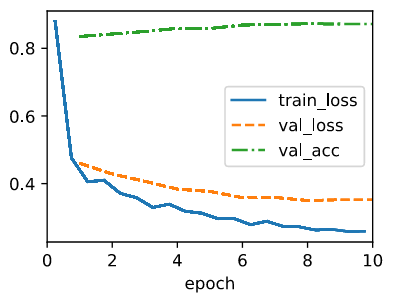

Arch(ResNXT): ((1,32,4,1),(1,64,4,1))
Batch_Size: 512 | Learning_rate: 0.5 | Time: 161.16670656204224 | Accuracy: tensor(0.8848, device='cuda:0') | Time Per Epoch:16.116670656204224 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9

Arch(ResNXT): ((1,8,2,1),(1,8,2,1))
Batch_Size: 768 | Learning_rate: 0.5 | Time: 151.79981207847595 | Accuracy: tensor(0.8255, device='cuda:0') | Time Per Epoch:15.179981207847595 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9

Arch(ResNXT): ((1,4,2,1),(1,4,2,1))
Batch_Size: 512 | Learning_rate: 1 | Time: 80.98000240325928 | Accuracy: tensor(0.7773, device='cuda:0') | Time Per Epoch:16.196000480651854 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9


Arch(ResNXT): ((1,8,2,1),(1,8,2,1))
Batch_Size: 512 | Learning_rate: 0.75 | Time: 88.93798637390137 | Accuracy: tensor(0.8379, device='cuda:0') | Time Per Epoch:17.787597274780275 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Arch(ResNXT): ((1,4,1,1),(1,4,1,1))
Batch_Size: 512 | Learning_rate: 1 | Time: 80.98000240325928 | Accuracy: tensor(0.7773, device='cuda:0') | Time Per Epoch:16.196000480651854 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Arch(ResNXT): ((1,4,4,1),(1,4,4,1))
Batch_Size: 512 | Learning_rate: 1 | Time: 76.39841079711914 | Accuracy: tensor(0.7578, device='cuda:0') | Time Per Epoch:15.279682159423828 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Arch(ResNXT): ((1,8,4,1),(1,8,4,1))
Batch_Size: 512 | Learning_rate: 1 | Time: 86.53182744979858 | Accuracy: tensor(0.8340, device='cuda:0') | Time Per Epoch:17.306365489959717 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Current Benchmark (Simplifying the arch any further does not decrease time greatly):

Arch(ResNXT): ((1,8,2,1),(1,8,2,1))
Batch_Size: 768 | Learning_rate: 0.5 | Time: 151.79981207847595 | Accuracy: tensor(0.8255, device='cuda:0') | Time Per Epoch:15.179981207847595 | Step_Size: 1 | Gamma: 0.75 | Weight Decay: 1e-05 | Momentum: 0.9

Arch(ResNet): ((1,8),(1,8))
Batch_Size: 768 | Learning_rate: 0.65 | Time: 80.94975280761719 | Accuracy: tensor(0.8229, device='cuda:0') | Time Per Epoch:16.18995056152344 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9


Arch(ResNet): [((1,8),(1,8)),((2,8),(2,8)),((1,8),(1,16)),((2,8),(2,16))]

Batch_Size: 768 | Learning_rate: 0.65 | Time: 76.20542454719543 | Accuracy: tensor(0.8229, device='cuda:0') | Time Per Epoch:15.241084909439087 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Batch_Size: 768 | Learning_rate: 0.65 | Time: 79.71913814544678 | Accuracy: tensor(0.7734, device='cuda:0') | Time Per Epoch:15.943827629089355 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Batch_Size: 768 | Learning_rate: 0.65 | Time: 71.28023409843445 | Accuracy: tensor(0.8333, device='cuda:0') | Time Per Epoch:14.25604681968689 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Batch_Size: 768 | Learning_rate: 0.65 | Time: 75.46048617362976 | Accuracy: tensor(0.8372, device='cuda:0') | Time Per Epoch:15.092097234725951 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

New Benchmark:

Arch(ResNet):[((1,8),(1,32)),((1,8),(2,16))]

Batch_Size: 768 | Learning_rate: 0.65 | Time: 70.93957018852234 | Accuracy: tensor(0.8607, device='cuda:0') | Time Per Epoch:14.187914037704468 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Can go down to three epochs instead as well, resulting in no effect from the lr schedule.

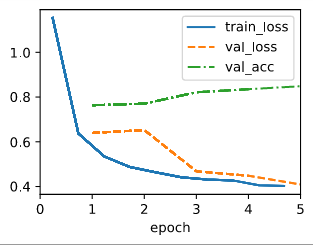

Batch_Size: 768 | Learning_rate: 0.65 | Time: 76.93992710113525 | Accuracy: tensor(0.8008, device='cuda:0') | Time Per Epoch:15.38798542022705 | Step_Size: 2 | Gamma: 0.6 | Weight Decay: 1e-05 | Momentum: 0.9

Inorder to Further analyse if I can optimise the hyper-parameters I ran a small sweep:

Batch_Size: 512 | Learning_rate: 1 | Time: 84.81999158859253 | Accuracy: tensor(0.8398, device='cuda:0') | Time Per Epoch:16.963998317718506 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 512 | Learning_rate: 1.5 | Time: 78.30153107643127 | Accuracy: tensor(0.7500, device='cuda:0') | Time Per Epoch:15.660306215286255 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 512 | Learning_rate: 2 | Time: 78.2908308506012 | Accuracy: tensor(0.7715, device='cuda:0') | Time Per Epoch:15.65816617012024 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 600 | Learning_rate: 1 | Time: 75.67519164085388 | Accuracy: tensor(0.8050, device='cuda:0') | Time Per Epoch:15.135038328170776 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 600 | Learning_rate: 1.5 | Time: 78.70058989524841 | Accuracy: tensor(0.7900, device='cuda:0') | Time Per Epoch:15.740117979049682 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 600 | Learning_rate: 2 | Time: 77.36104917526245 | Accuracy: tensor(0.7767, device='cuda:0') | Time Per Epoch:15.47220983505249 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 768 | Learning_rate: 1 | Time: 76.81171131134033 | Accuracy: tensor(0.8151, device='cuda:0') | Time Per Epoch:15.362342262268067 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 768 | Learning_rate: 1.5 | Time: 74.80003476142883 | Accuracy: tensor(0.8060, device='cuda:0') | Time Per Epoch:14.960006952285767 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 768 | Learning_rate: 2 | Time: 73.53339076042175 | Accuracy: tensor(0.8099, device='cuda:0') | Time Per Epoch:14.70667815208435 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 900 | Learning_rate: 1 | Time: 77.84709548950195 | Accuracy: tensor(0.8544, device='cuda:0') | Time Per Epoch:15.56941909790039 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 900 | Learning_rate: 1.5 | Time: 72.92954564094543 | Accuracy: tensor(0.8356, device='cuda:0') | Time Per Epoch:14.585909128189087 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 900 | Learning_rate: 2 | Time: 72.94722580909729 | Accuracy: tensor(0.7722, device='cuda:0') | Time Per Epoch:14.589445161819459 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 1024 | Learning_rate: 1 | Time: 72.51581335067749 | Accuracy: tensor(0.8535, device='cuda:0') | Time Per Epoch:14.503162670135499 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 1024 | Learning_rate: 1.5 | Time: 72.66688752174377 | Accuracy: tensor(0.7842, device='cuda:0') | Time Per Epoch:14.533377504348755 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

Batch_Size: 1024 | Learning_rate: 2 | Time: 74.00417804718018 | Accuracy: tensor(0.8242, device='cuda:0') | Time Per Epoch:14.800835609436035 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

**Suprisingly the Optimal Point has now shifted to:**
Batch_Size: 1024 | Learning_rate: 1 | Time: 72.51581335067749 | Accuracy: tensor(0.8535, device='cuda:0') | Time Per Epoch:14.503162670135499 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-05 | Momentum: 0.8

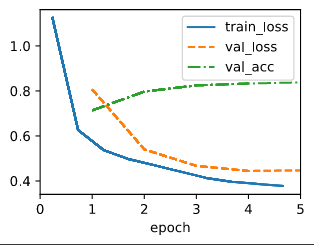

**New Benchmark with further tuning:**

Batch_Size: 1024 | Learning_rate: 1.5 | Time: 67.66494107246399 | Accuracy: tensor(0.8262, device='cuda:0') | Time Per Epoch:13.532988214492798 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-06 | Momentum: 0.6

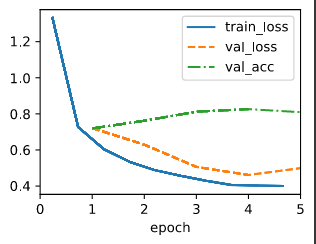

Batch_Size: 1024 | Learning_rate: 1.75 | Time: 67.00695061683655 | Accuracy: tensor(0.8096, device='cuda:0') | Time Per Epoch:13.40139012336731 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-06 | Momentum: 0.6

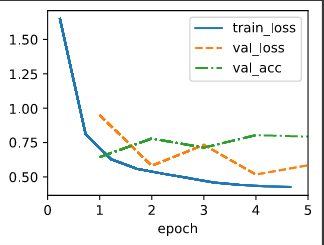




```
# MOD3: batch_size changes, weight_decay, momentum and learning_rate scheduler.

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Architecture:
arch = ((1,8),(1,32)) # -> Most Efficient Arch for this 512 Batch Size.
#arch = ((1,8,2,1),(1,8,2,1))
#archs = [((1,8),(1,32)),((1,8),(2,16))]

#def train_CUSmodelv2(arch, b1_ks, b1_stride, b1_padd, b2_ks, b2_stride, b2_padd, res_kernel_size, res_padding, res_strides, data, learn_rate, epochs, in_bs, size, n_gpu, momentum = None, weight_decay = None, step_size = None, gamma = None):
b1_ks = 9
b1_stride = 3
b1_padd = 3
b2_ks = 5
b2_stride = 2
b2_padd = 3
res_kernel_size = 5
res_padding = 1
res_strides = 3

#Declare Hyper-parameters
learning_rates = [1.75]
batch_sizes = [1024]
size = (96,96)
epoch = 5

#Learning Rate Scheduler Parameters
step_size = 3
gamma = 0.65

#Optimizer Parameters
momentum = 0.6
weight_decay = 1e-6

output = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        #Print Run Data
        print("Data: ",batch_size,"|",learning_rate,"|",step_size,"|",gamma,"|",momentum,"|",weight_decay)

        #Run Training:
        data = d2l.FashionMNIST(batch_size=batch_size)
        start_time = time.time()
        """model = train_model(data, learning_rate, epoch, batch_size, size, n_gpu,
                            step_size = step_size, gamma = gamma,
                            momentum = momentum, weight_decay = weight_decay)"""
        model = train_CUSmodel(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)
        """model = train_CUSmodelv2(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              b1_ks = b1_ks, b1_stride = b1_stride, b1_padd = b1_padd,
                              b2_ks = b2_ks, b2_stride = b2_stride, b2_padd = b2_padd,
                              res_kernel_size = res_kernel_size, res_padding = res_padding,
                              res_strides = res_strides, step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)"""
        """model = train_NXTmodel(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)"""
        run_time = time.time() - start_time

        #Generate Accuracy of Model:
        X,y = next(iter(data.get_dataloader(False)))
        model.eval()
        with torch.no_grad():
            Y_hat = model(torch.FloatTensor(X).to(device))

        #Print Output Data:
        output_str = "Batch_Size: " + str(batch_size) + " | Learning_rate: " + str(learning_rate) + " | Time: " + str(run_time) + " | Accuracy: " + str(model.accuracy(Y_hat,y.to(device))) + " | Time Per Epoch:" + str(run_time/epoch) + " | Step_Size: " + str(step_size) + " | Gamma: " + str(gamma) + " | Weight Decay: " + str(weight_decay) + " | Momentum: " + str(momentum) + "\n"
        output.append(output_str)


for text in output:
    print(text)

```

Considering that creating the model, trainer and initializing the model are also taken for time. It would be preferred to only capture the training time.


Final Benchmark:
Batch_Size: 1024 | Learning_rate: 1.5 | Time: 66.80351638793945 | Accuracy: tensor(0.8154, device='cuda:0') | Time Per Epoch:13.360703277587891 | Step_Size: 3 | Gamma: 0.65 | Weight Decay: 1e-06 | Momentum: 0.6

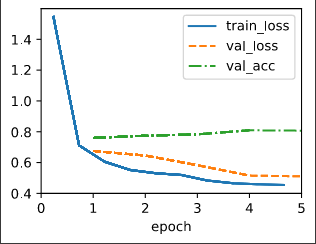

In [ ]:
# MOD3: batch_size changes, weight_decay, momentum and learning_rate scheduler.

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Architecture:
arch = ((1,8),(1,32)) # -> Most Efficient Arch for this 512 Batch Size.
#arch = ((1,8,2,1),(1,8,2,1))
#archs = [((1,8),(1,32)),((1,8),(2,16))]

#def train_CUSmodelv2(arch, b1_ks, b1_stride, b1_padd, b2_ks, b2_stride, b2_padd, res_kernel_size, res_padding, res_strides, data, learn_rate, epochs, in_bs, size, n_gpu, momentum = None, weight_decay = None, step_size = None, gamma = None):
b1_ks = 9
b1_stride = 3
b1_padd = 3
b2_ks = 5
b2_stride = 2
b2_padd = 3
res_kernel_size = 5
res_padding = 1
res_strides = 3

#Declare Hyper-parameters
learning_rates = [1.5]
batch_sizes = [1024]
size = (96,96)
epoch = 5

#Learning Rate Scheduler Parameters
step_size = 3
gamma = 0.65

#Optimizer Parameters
momentum = 0.6
weight_decay = 1e-6

output = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        #Print Run Data
        print("Data: ",batch_size,"|",learning_rate,"|",step_size,"|",gamma,"|",momentum,"|",weight_decay)

        #Run Training:
        data = d2l.FashionMNIST(batch_size=batch_size)
        """model, run_time = train_model(data, learning_rate, epoch, batch_size, size, n_gpu,
                            step_size = step_size, gamma = gamma,
                            momentum = momentum, weight_decay = weight_decay)"""
        model, run_time = train_CUSmodel(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)
        """model, run_time = train_CUSmodelv2(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              b1_ks = b1_ks, b1_stride = b1_stride, b1_padd = b1_padd,
                              b2_ks = b2_ks, b2_stride = b2_stride, b2_padd = b2_padd,
                              res_kernel_size = res_kernel_size, res_padding = res_padding,
                              res_strides = res_strides, step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)"""
        """model, run_time = train_NXTmodel(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)"""

        #Generate Accuracy of Model:
        X,y = next(iter(data.get_dataloader(False)))
        model.eval()
        with torch.no_grad():
            Y_hat = model(torch.FloatTensor(X).to(device))

        #Print Output Data:
        output_str = "Batch_Size: " + str(batch_size) + " | Learning_rate: " + str(learning_rate) + " | Time: " + str(run_time) + " | Accuracy: " + str(model.accuracy(Y_hat,y.to(device))) + " | Time Per Epoch:" + str(run_time/epoch) + " | Step_Size: " + str(step_size) + " | Gamma: " + str(gamma) + " | Weight Decay: " + str(weight_decay) + " | Momentum: " + str(momentum) + "\n"
        output.append(output_str)


for text in output:
    print(text)


Data:  1024 | 1.5 | 3 | 0.65 | 0.6 | 1e-06


RuntimeError: ignored

**Implementing Custom Datamodule for CIFAR Dataset.**

In [ ]:
class CIFAR10(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(32, 32)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.CIFAR10(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.CIFAR10(
            root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """Return text labels."""
        labels = ['air plane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                          num_workers=self.num_workers)

    def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
        """Plot a list of images."""
        raise NotImplementedError

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

**Using exsisting models in current setup to test for CIFAR:**

Benchmark:

Arch: ResNet ((3,64),(5,256),(7,512),(3,1024))

Batch_Size: 512 | Learning_rate: 0.001 | Time: 1478.9297199249268 | Accuracy: tensor(0.6074, device='cuda:0') | Time Per Epoch:73.94648599624634 | Step_Size: 5 | Gamma: 0.9 | Weight Decay: 1e-05 | Momentum: 0.9


Arch: ResNet ((4,64),(6,256),(7,512),(5,1024))

Batch_Size: 512 | Learning_rate: 0.0015 | Time: 1845.0721235275269 | Accuracy: tensor(0.5859, device='cuda:0') | Time Per Epoch:92.25360617637634 | Step_Size: 4 | Gamma: 0.9 | Weight Decay: 1e-05 | Momentum: 0.9

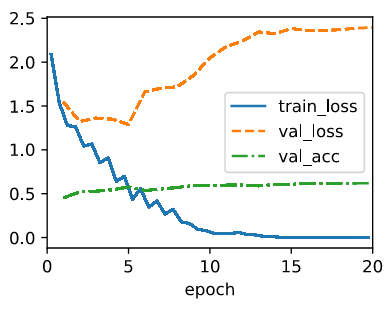


Batch_Size: 512 | Learning_rate: 0.005 | Time: 668.7086565494537 | Accuracy: tensor(0.6523, device='cuda:0') | Time Per Epoch:66.87086565494538 | Step_Size: 5 | Gamma: 0.85 | Weight Decay: 0.0001 | Momentum: 0.9

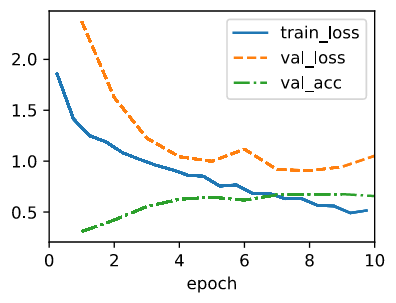

Batch_Size: 512 | Learning_rate: 0.005 | Time: 736.7535207271576 | Accuracy: tensor(0.7383, device='cuda:0') | Time Per Epoch:73.67535207271575 | Step_Size: 5 | Gamma: 0.85 | Weight Decay: 0.0001 | Momentum: 0.9

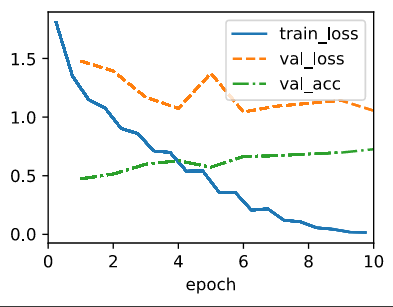

Batch_Size: 512 | Learning_rate: 0.05 | Time: 755.4510297775269 | Accuracy: tensor(0.7969, device='cuda:0') | Time Per Epoch:75.54510297775269 | Step_Size: 5 | Gamma: 0.65 | Weight Decay: 0.0001 | Momentum: 0.9

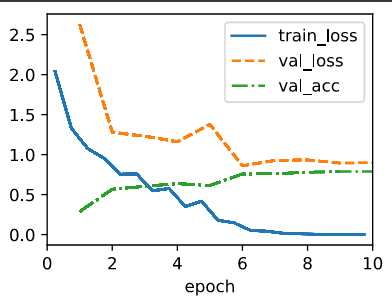

Finally Acheived 80% Accuracy:

Batch_Size: 512 | Learning_rate: 0.05 | Time: 730.3520739078522 | Accuracy: tensor(0.8145, device='cuda:0') | Time Per Epoch:73.03520739078522 | Step_Size: 6 | Gamma: 0.75 | Weight Decay: 0.0001 | Momentum: 0.9


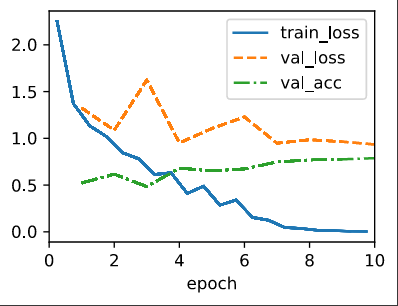

Batch_Size: 512 | Learning_rate: 0.05 | Time: 748.8517696857452 | Accuracy: tensor(0.8008, device='cuda:0') | Time Per Epoch:74.88517696857453 | Step_Size: 6 | Gamma: 0.75 | Weight Decay: 0.0001 | Momentum: 0.9



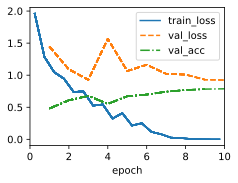

In [ ]:
# MOD4: batch_size changes, weight_decay, momentum and learning_rate scheduler.

#Hardware Variables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_gpu = 1

#Architecture:
arch = ((2,64),(2,128),(2,256),(2,512)) # -> ResNet18
#archs = [((1,8),(1,32)),((1,8),(2,16))]
#arch = ((2,64,8,1),(2,128,8,1),(2,64,8,1)) # -> ResNeXt50

#Declare Hyper-parameters
learning_rates = [0.05]
batch_sizes = [512]
size = (128,128)
epoch = 10

#Learning Rate Scheduler Parameters
step_size = 6
gamma = 0.75

#Optimizer Parameters
momentum = 0.9
weight_decay = 1e-4

output = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        #Print Run Data
        print("Data: ",batch_size,"|",learning_rate,"|",step_size,"|",gamma,"|",momentum,"|",weight_decay)

        #Run Training:
        data = CIFAR10(batch_size=batch_size, resize = size)
        """model, run_time = train_model(data, learning_rate, epoch, batch_size, size, n_gpu,
                            step_size = step_size, gamma = gamma,
                            momentum = momentum, weight_decay = weight_decay)"""
        model, run_time = train_CUSmodel(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)
        """model, run_time = train_CUSmodelv2(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              b1_ks = b1_ks, b1_stride = b1_stride, b1_padd = b1_padd,
                              b2_ks = b2_ks, b2_stride = b2_stride, b2_padd = b2_padd,
                              res_kernel_size = res_kernel_size, res_padding = res_padding,
                              res_strides = res_strides, step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)"""
        """model, run_time = train_NXTmodel(arch, data, learning_rate, epoch, batch_size, size, n_gpu,
                              step_size = step_size, gamma = gamma,
                              momentum = momentum, weight_decay = weight_decay)"""

        #Generate Accuracy of Model:
        X,y = next(iter(data.get_dataloader(False)))
        model.eval()
        with torch.no_grad():
            Y_hat = model(torch.FloatTensor(X).to(device))

        #Print Output Data:
        output_str = "Batch_Size: " + str(batch_size) + " | Learning_rate: " + str(learning_rate) + " | Time: " + str(run_time) + " | Accuracy: " + str(model.accuracy(Y_hat,y.to(device))) + " | Time Per Epoch:" + str(run_time/epoch) + " | Step_Size: " + str(step_size) + " | Gamma: " + str(gamma) + " | Weight Decay: " + str(weight_decay) + " | Momentum: " + str(momentum) + "\n"
        output.append(output_str)


for text in output:
    print(text)


**CHEEKY TESTING SPACE**